# Evaluation of test year GCM-driven run

In [1]:
import valenspy as vp
from valenspy._utilities import load_yml
from valenspy.preprocessing_tasks.select import select_point
from valenspy.diagnostic_functions import mean_bias, mean_absolute_error, root_mean_square_error, spearman_correlation, perkins_skill_score, time_series_spatial_mean
from valenspy.diagnostic_visualizations import plot_time_series
from pathlib import Path

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd


# define machine name - used for paths of (observational) datasets
machine = 'hortense'

manager = vp.InputManager(machine=machine)


## TO DO
1. Add -10 at boundaries
2. Include checks for the extremes

## 0. Pre-defining 

In [2]:
# Define reference datasets
reference = 'ERA5'
test_set = 'EC-Earth'
domain = 'EUR11'
model = "CCLM"

variable = 'tas'
daily_statistic = "mean"

## 1. Functions
--> fully tested, are working 

In [3]:
def load_data_exp(variable, model, experiment):

    if variable in ['tas','clt', 'clh', 'clm', 'cll']:
        daily_statistic = "mean"
    #    ds_exp = ds_obs.resample(time='1D').mean()

    elif variable == 'pr': 
 
        daily_statistic = "sum"
   #     ds_obs = ds_obs.resample(time='1D').sum()

    elif variable == "tasmax": 
        daily_statistic = "max"
       # ds_obs = ds_obs.resample(time='1D').max()

    ds_mod = manager.load_data(model, [variable], freq="hourly", path_identifiers=[experiment, daily_statistic])


    ds_mod['time'] = ds_mod['time'].dt.floor('D')


    da_exp = ds_mod[variable].compute()

    return da_exp

In [4]:
def get_spaghetti_GLUE(ds_eval: xr.Dataset, ds_exp: xr.Dataset, variable: str): 

    """
    Plots the yearly cycle for each year in the evaluation dataset (`da_eval`)
    and the experimental dataset (`da_exp`), starting on January 1st for all.

    Parameters:
        da_eval (xarray.Dataset): Evaluation dataset with multiple years.
        da_exp (xarray.Dataset): Experimental dataset with a single year.
        variable (str): The name of the variable to plot.

    Returns:
        None: Displays the plot.
    """
    plt.figure(figsize = (20,5))
    
    # Exctract unique years
    years_eval = np.unique(pd.to_datetime(ds_eval.time).year)
    years_exp = np.unique(pd.to_datetime(ds_exp.time).year)

    # # Loop over all years:
    for yr in years_eval:
        ds_year = ds_eval.sel(time=ds_eval.time.dt.year.isin([yr]))
        print("In year " + str(yr) + ' we have ' + str(len(ds_year["time"])) + " datapoints.")
        da_year = ds_year[variable]
        df_year = da_year
        da_year["doy"] = da_year['time'].dt.dayofyear

        plt.plot(da_year['doy'], da_year, color = "grey")

    for yr in years_exp:
        ds_year = ds_exp.sel(time=ds_exp.time.dt.year.isin([yr]))
        print("In year " + str(yr) + ' we have ' + str(len(ds_year["time"])) + " datapoints.")
        da_year = ds_year[variable]
        df_year = da_year
        da_year["doy"] = da_year['time'].dt.dayofyear

        plt.plot(da_year['doy'], da_year, label="Experimental Dataset" , color = "red")

    # Customize Plot
    plt.title(f"Yearly Cycle of {variable}")
    plt.xlabel("Day of Year")
    plt.ylabel(variable)
    plt.legend(loc='upper right', fontsize='small', ncol=2)  # Adjust legend
    plt.grid()
    plt.show()


In [5]:
import xarray as xr

def rank_years(da: xr.DataArray, dim: str = "year") -> dict:
    """
    Ranks yearly values in an xarray DataArray and returns the years with the highest and lowest values.
    
    Parameters:
        da (xr.DataArray): Input DataArray with a time dimension representing years.
        dim (str): The dimension along which to rank. Default is "year".
    
    Returns:
        dict: A dictionary with the highest and lowest year and their corresponding values.
              Example: {"highest": {"year": 2000, "value": 34.5}, 
                        "lowest": {"year": 1990, "value": -23.1}}
    """
    # Ensure the DataArray has the specified dimension
    if dim not in da.dims:
        raise ValueError(f"Dimension '{dim}' not found in the DataArray.")
    
    # Identify the highest and lowest values
    highest_idx = da.argmax(dim=dim).item()  # Index of the max value
    lowest_idx = da.argmin(dim=dim).item()   # Index of the min value
    
    # Retrieve the corresponding years (assuming `dim` coordinates represent years)
    highest_year = da[dim].isel({dim: highest_idx}).item()
    lowest_year = da[dim].isel({dim: lowest_idx}).item()
    
    # Retrieve the corresponding values
    highest_value = da.isel({dim: highest_idx}).item()
    lowest_value = da.isel({dim: lowest_idx}).item()
    
    return {
        "highest": {"year": highest_year, "value": highest_value},
        "lowest": {"year": lowest_year, "value": lowest_value},
    }

# Example usage
# Assuming `da` has yearly data with dimension "year"
# result = rank_years(da, dim="year")
# print(result)


In [6]:
def crop_outer_box(da: xr.DataArray, n_points: int = 10) -> xr.DataArray:
    """
    Crops the outer box of an xarray DataArray by removing a specified number of points
    from each edge along all dimensions.
    
    Parameters:
        da (xr.DataArray): The input DataArray.
        n_points (int): The number of points to remove from each edge. Default is 10.
    
    Returns:
        xr.DataArray: The cropped DataArray.
    """
    # Validate the DataArray has sufficient points along each dimension
    for dim in ['rlon','rlat']:
        if da.sizes[dim] <= 2 * n_points:
            raise ValueError(
                f"Dimension '{dim}' is too small to crop {n_points} points from each side."
            )
    
    # Slice each dimension
    sliced_da = da.isel({dim: slice(n_points, -n_points) for dim in da.dims})
    
    return sliced_da

# Example usage
# Assuming `da` is your xarray.DataArray
# cropped_da = crop_outer_box(da, n_points=10)


## 2. Running

In [7]:
experiment = "CB2_CCLM_EUR11_EC-Earth_test"
da_exp = manager.load_data(model, [variable], freq="monthly", path_identifiers=[experiment, daily_statistic])
da_exp

File paths found:
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/EUR11_EC-Earth_test/CB2_CCLM_EUR11_EC-Earth_test/T_2M/monthly/T_2M_daymean_199505.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/EUR11_EC-Earth_test/CB2_CCLM_EUR11_EC-Earth_test/T_2M/monthly/T_2M_daymean_199510.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/EUR11_EC-Earth_test/CB2_CCLM_EUR11_EC-Earth_test/T_2M/monthly/T_2M_daymean_199507.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/EUR11_EC-Earth_test/CB2_CCLM_EUR11_EC-Earth_test/T_2M/monthly/T_2M_daymean_199506.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/EUR11_EC-Earth_test/CB2_CCLM_EUR11_EC-Earth_test/T_2M/monthly/T_2M_daymean_199512.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/EUR11_EC-Earth_test/CB2_CCLM_EUR11_EC-Earth_test/T_2M/monthly/T_2M_daymean_199502.nc
/dod

<xarray.Dataset> Size: 284MB
Dimensions:       (time: 365, bnds: 2, rlat: 434, rlon: 446)
Coordinates:
  * time          (time) datetime64[ns] 3kB 1995-01-01T11:30:00 ... 1995-12-3...
    lon           (rlat, rlon) float32 774kB dask.array<chunksize=(434, 446), meta=np.ndarray>
    lat           (rlat, rlon) float32 774kB dask.array<chunksize=(434, 446), meta=np.ndarray>
  * rlon          (rlon) float32 2kB -29.58 -29.48 -29.36 ... 19.15 19.25 19.36
  * rlat          (rlat) float32 2kB -24.58 -24.48 -24.36 ... 22.83 22.93 23.05
    height_2m     float32 4B 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds     (time, bnds) datetime64[ns] 6kB dask.array<chunksize=(31, 2), meta=np.ndarray>
    rotated_pole  (time) |S1 365B b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    tas           (time, rlat, rlon) float32 283MB dask.array<chunksize=(31, 434, 446), meta=np.ndarray>
Attributes: (12/18)
    CDI:               Climate Data Interface version 2.3.0 (https://mpimet.m...
    Conventions:       CF-1.4
    source:            cosmo6.00_clm2, int2lm3.0_clm1
    institution:       KU Leuven, Leuven, BELGIUM
    title:             EUR11_NU_TT_EC
    project_id:        CORDEXbe2
    ...                ...
    history:           Tue Nov 19 14:16:43 2024: cdo mergetime daily/T_2M_day...
    frequency:         day
    CDO:               Climate Data Operators version 2.3.0 (https://mpimet.m...
    freq:              monthly
    path_identifiers:  ['CB2_CCLM_EUR11_EC-Earth_test', 'mean']
    dataset:           CCLM

In [8]:
experiment = "CB2_CCLM_EUR11_ERA5_evaluation"
da_eval = manager.load_data(model, [variable], period = [1980,1999], freq="monthly", path_identifiers=[experiment,daily_statistic])
da_eval
# for 3 years: took around 3.5 minutes: 3 for finding folder 20s for loading data
# for 20 years: took around 6.20 minutes

File paths found:
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/monthly/T_2M_daymean_198308.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/monthly/T_2M_daymean_198507.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/monthly/T_2M_daymean_198509.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/monthly/T_2M_daymean_199802.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/monthly/T_2M_daymean_198605.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_eval

<xarray.Dataset> Size: 6GB
Dimensions:       (time: 7305, bnds: 2, rlat: 434, rlon: 446)
Coordinates:
  * time          (time) datetime64[ns] 58kB 1980-01-01T11:30:00 ... 1999-12-...
    lon           (rlat, rlon) float32 774kB dask.array<chunksize=(434, 446), meta=np.ndarray>
    lat           (rlat, rlon) float32 774kB dask.array<chunksize=(434, 446), meta=np.ndarray>
  * rlon          (rlon) float32 2kB -29.58 -29.48 -29.36 ... 19.15 19.25 19.36
  * rlat          (rlat) float32 2kB -24.58 -24.48 -24.36 ... 22.83 22.93 23.05
    height_2m     float32 4B 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds     (time, bnds) datetime64[ns] 117kB dask.array<chunksize=(31, 2), meta=np.ndarray>
    rotated_pole  (time) |S1 7kB b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    tas           (time, rlat, rlon) float32 6GB dask.array<chunksize=(31, 434, 446), meta=np.ndarray>
Attributes: (12/19)
    CDI:               Climate Data Interface version 2.3.0 (https://mpimet.m...
    Conventions:       CF-1.4
    source:            cosmo6.00_clm2, int2lm3.0_clm1
    institution:       KU Leuven, Leuven, BELGIUM
    title:             CB2_CCLM_EUR11_ERA5_evaluation
    project_id:        CORDEXbe2
    ...                ...
    frequency:         day
    CDO:               Climate Data Operators version 2.3.0 (https://mpimet.m...
    freq:              monthly
    path_identifiers:  ['CB2_CCLM_EUR11_ERA5_evaluation', 'mean']
    dataset:           CCLM
    period:            [1980, 1999]

In [9]:
from valenspy.preprocessing_tasks.select import select_region, select_point

# Define the coordinates
d_point_coords = {
    'opwijk'    : (4.18, 50.97), 
    'betrix'    : (5.25, 49.854),
    'north_sea' : (2.465, 51.63),
    'channel'   : (-1.05, 50.14)
}
point_coord = d_point_coords['opwijk']


In [10]:
#da_eval_crop = crop_outer_box(da_eval)
#da_exp_crop = crop_outer_box(da_exp)

In [11]:
ds_mean_eval = da_eval.mean(dim=["rlat", "rlon"])
ds_mean_exp = da_exp.mean(dim = ["rlat", "rlon"])
ds_mean_eval

<xarray.Dataset> Size: 212kB
Dimensions:       (time: 7305, bnds: 2)
Coordinates:
  * time          (time) datetime64[ns] 58kB 1980-01-01T11:30:00 ... 1999-12-...
    height_2m     float32 4B 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds     (time, bnds) datetime64[ns] 117kB dask.array<chunksize=(31, 2), meta=np.ndarray>
    rotated_pole  (time) |S1 7kB b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    tas           (time) float32 29kB dask.array<chunksize=(31,), meta=np.ndarray>
Attributes: (12/19)
    CDI:               Climate Data Interface version 2.3.0 (https://mpimet.m...
    Conventions:       CF-1.4
    source:            cosmo6.00_clm2, int2lm3.0_clm1
    institution:       KU Leuven, Leuven, BELGIUM
    title:             CB2_CCLM_EUR11_ERA5_evaluation
    project_id:        CORDEXbe2
    ...                ...
    frequency:         day
    CDO:               Climate Data Operators version 2.3.0 (https://mpimet.m...
    freq:              monthly
    path_identifiers:  ['CB2_CCLM_EUR11_ERA5_evaluation', 'mean']
    dataset:           CCLM
    period:            [1980, 1999]

## 2. Calculation and visualisation of time series
in this example, the reference data is split up for each year. Each year is plot in a spaghetti plot, where the test year is also included.
Additionally, the P5, P50 and P95 of the reference data is included for every day of every year.

In year 1980 we have 366 datapoints.
In year 1981 we have 365 datapoints.
In year 1982 we have 365 datapoints.
In year 1983 we have 365 datapoints.
In year 1984 we have 366 datapoints.
In year 1985 we have 365 datapoints.
In year 1986 we have 365 datapoints.
In year 1987 we have 365 datapoints.
In year 1988 we have 366 datapoints.
In year 1989 we have 365 datapoints.
In year 1990 we have 365 datapoints.
In year 1991 we have 365 datapoints.
In year 1992 we have 366 datapoints.
In year 1993 we have 365 datapoints.
In year 1994 we have 365 datapoints.
In year 1995 we have 365 datapoints.
In year 1996 we have 366 datapoints.
In year 1997 we have 365 datapoints.
In year 1998 we have 365 datapoints.
In year 1999 we have 365 datapoints.
In year 1995 we have 365 datapoints.


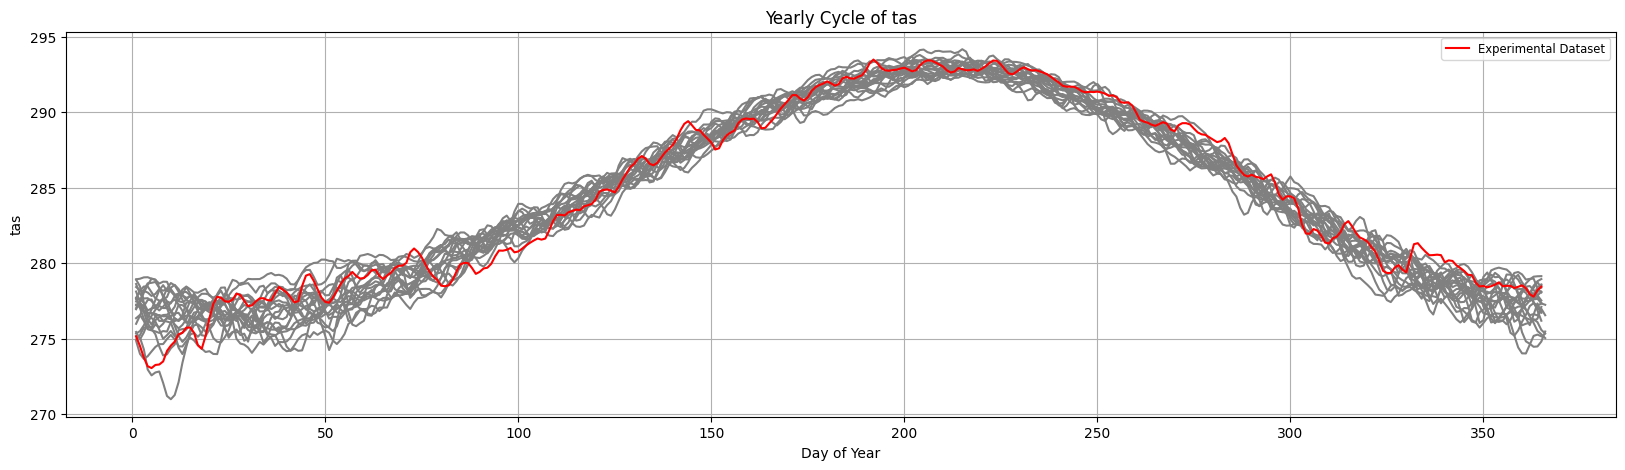

In [12]:
ds_test = get_spaghetti_GLUE(ds_mean_eval, ds_mean_exp, variable = 'tas')

In [ ]:
# d_rankyears = rank_years(ds_mean_eval.groupby('time.year').mean()[1:-1])
# d_rankyears

ValueError: Unsupported key-type <class 'slice'>

## 3. Calculation of P5, P50, P95 for each year 
In this example, the P5, P50 and P95 for each year are calculated for the reference run and the test year. 

### Calculate daily and yearly statistics
- Mean, median
- min, max
- standard deviation
- percentiles

### Visualize yearly statistics
- boxplot
- lineplots


In [14]:
import xarray as xr

def get_yearly_stats(dataset, variable, frequency="yearly", calc_mean=True, calc_median=False,
                     calc_min=True, calc_max=True, calc_std=True, percentiles=None):
    """
    Compute statistics for a specified variable in an xarray Dataset, either yearly or daily within each year.
    
    Parameters:
        dataset (xr.Dataset): The input dataset containing the variable.
        variable (str): The name of the variable to compute statistics on.
        frequency (str): "yearly" for statistics per year, "daily" for each day within the year (default: "yearly").
        calc_mean (bool): Whether to calculate the mean (default: True).
        calc_median (bool): Whether to calculate the median (default: False).
        calc_min (bool): Whether to calculate the minimum (default: True).
        calc_max (bool): Whether to calculate the maximum (default: True).
        calc_std (bool): Whether to calculate the standard deviation (default: True).
        percentiles (list): List of percentiles to compute (default: None).
        
    Returns:
        xr.Dataset: A Dataset containing the requested statistics for the selected variable.
    """
    if variable not in dataset:
        raise ValueError(f"Variable '{variable}' not found in the dataset.")
    
    # Group data by the specified frequency
    if frequency == "yearly":
        grouped_data = dataset[variable].groupby("time.year")
    elif frequency == "daily":
        grouped_data = dataset[variable].groupby("time.dayofyear")
    else:
        raise ValueError("Frequency must be either 'yearly' or 'daily'.")
    
    # Create a dictionary to store computed statistics
    stats = {}
    if calc_mean:
        stats['mean'] = grouped_data.mean(dim="time")
    if calc_median:
        stats['median'] = grouped_data.reduce(xr.DataArray.quantile, dim="time", q=0.5)
    if calc_min:
        stats['min'] = grouped_data.min(dim="time")
    if calc_max:
        stats['max'] = grouped_data.max(dim="time")
    if calc_std:
        stats['std'] = grouped_data.std(dim="time")
    if percentiles:
        for p in percentiles:
            stats[f"p{int(p)}"] = grouped_data.reduce(
                xr.DataArray.quantile, dim="time", q=p/100
            )
    
    # Create a new Dataset with the statistics as variables
    stats_dataset = xr.Dataset(stats)
    
    return stats_dataset

In [15]:
stat_eval_daily= get_yearly_stats(dataset = ds_mean_eval, variable = variable, frequency="daily")
stat_exp_daily = get_yearly_stats(dataset = ds_mean_exp, variable = variable, frequency="daily")
stat_eval_yearly= get_yearly_stats(dataset = ds_mean_eval, variable = variable, frequency="yearly")
stat_exp_yearly = get_yearly_stats(dataset = ds_mean_exp, variable = variable, frequency="yearly")

In [ ]:
import matplotlib.pyplot as plt

def plot_daily_stats(eval_dataset, test_dataset, variable, statistics):
    """
    Plots daily statistics from the evaluation dataset and compares them with the test dataset.
    
    Parameters:
        eval_dataset (xr.Dataset): The dataset containing evaluation statistics (mean, min, max, std, etc.).
        test_dataset (xr.Dataset): The dataset containing the test data.
        variable (str): The name of the variable in the test dataset to plot.
        statistics (list): List of statistics to plot from the evaluation dataset (e.g., ['mean', 'min', 'max', 'std']).
        
    Returns:
        matplotlib.figure.Figure: The generated plot figure.
    """
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Color map for statistics
    color_map = {
        'mean': 'blue',
        'min': 'green',
        'max': 'red',
        'std': 'grey'
    }

        # Plot the test dataset
    test_dataset["dayofyear"] = test_dataset['time'].dt.dayofyear
    ax.plot(
        test_dataset['dayofyear'], 
        test_dataset[variable], 
        label='Test Data', 
        color='black', 
        linestyle='--'
    )

    
    # Plot each requested statistic from the evaluation dataset
    for stat in statistics:
        if stat in eval_dataset:
            if stat == 'std':
                # Plot std as a shaded area around the mean
                if 'mean' in eval_dataset:
                    mean_values = eval_dataset['mean']
                    std_values = eval_dataset['std']
                    ax.fill_between(
                        eval_dataset['dayofyear'], 
                        mean_values - std_values, 
                        mean_values + std_values, 
                        color=color_map.get(stat, 'grey'), 
                        alpha=0.3, 
                        label='Standard Deviation'
                    )
                    print(f"Succesfully plotted {stat.capitalize()} ")
            else:
                # Plot other statistics as lines
                ax.plot(
                    eval_dataset['dayofyear'], 
                    eval_dataset[stat], 
                    label=f'Evaluation {stat.capitalize()}', 
                    color=color_map.get(stat, 'black')
                )
                print(f"Succesfully plotted {stat.capitalize()} ")


    
    # Add labels, legend, and title
    ax.set_title(f"Daily Statistics for {variable.capitalize()} (Evaluation vs Test)", fontsize=16)
    ax.set_xlabel("Day of Year", fontsize=14)
    ax.set_ylabel(f"{variable.capitalize()} Value", fontsize=14)
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return fig, ax


In [17]:
print(stat_exp_daily)

<xarray.Dataset> Size: 9kB
Dimensions:    (dayofyear: 365)
Coordinates:
    height_2m  float32 4B 2.0
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
Data variables:
    mean       (dayofyear) float32 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    min        (dayofyear) float32 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    max        (dayofyear) float32 1kB dask.array<chunksize=(1,), meta=np.ndarray>
    std        (dayofyear) float32 1kB dask.array<chunksize=(1,), meta=np.ndarray>


Succesfully plotted Mean 
Succesfully plotted Min 
Succesfully plotted Max 


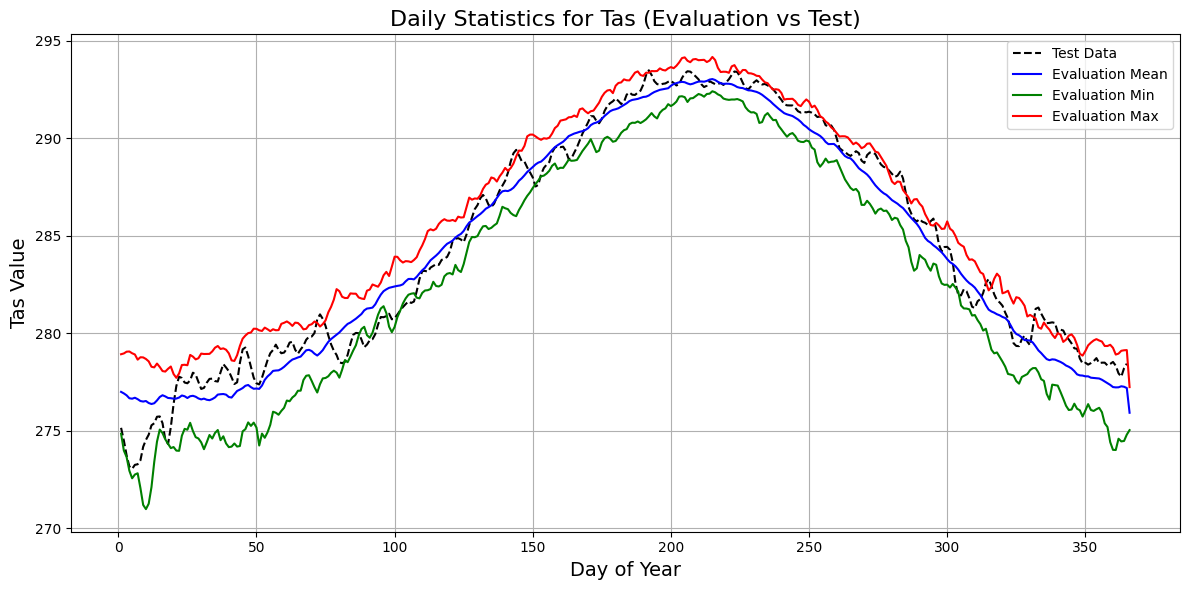

In [ ]:
# Takes very long
statistics_to_plot = ['mean', 'min', 'max']  # Example list of statistics

# Plot the daily statistics
fig = plot_daily_stats(stat_eval_daily, ds_mean_exp, statistics=statistics_to_plot, variable=variable)